# Triplet Loss

- model for minimizing triplet loss where one anchor image is compared with a positive image (image in the same outfit) and a negative image (image of same category of the positive image but not from the outfit)
- samples are created by taking items from all the outfits sequentially, i.e., if there are N items in an outfit then N-1 samples are created as (i1, i2), (i2, i3), ..., (iN-1, iN)
- each sample has three items (images and texts)
- images can be processed using CNN based encoders but model size becomes huge (~25 M) and training takes lot of time
- after getting embeddings of all the three items, $x_{o}$, $x_{+}$ and $x_{-}$, distances are calculated between the anchor and the positive item, $d_{o+} = ||x_o - x_+||$ and the negative item as, $d_{o-} = ||x_o - x_-||$
- then the loss is defined as $\mathcal{L} = max(d_{o+} - d_{o-} + margin, 0)$

Reference: Mariya I. Vasileva, Bryan A. Plummer, Krishna Dusad, Shreya Rajpal, Ranjitha Kumar, and David Forsyth. 
Learning type-aware embeddings for fashion copatibility. In ECCV, 2018.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
from collections import Counter
from PIL import Image
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tqdm import tqdm
import pickle

import sys
# sys.path.insert(0, "/recsys_data/RecSys/fashion/automl/efficientnetv2")
# import effnetv2_model

%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
base_dir = "/recsys_data/RecSys/fashion/polyvore-dataset/polyvore_outfits"
data_type = "nondisjoint" # "nondisjoint", "disjoint"
train_dir = os.path.join(base_dir, data_type)
image_dir = os.path.join(base_dir, "images")
embed_dir = "/recsys_data/RecSys/fashion/polyvore-dataset/precomputed"
train_json = "train.json"
valid_json = "valid.json"
test_json = "test.json"

train_file = "compatibility_train.txt"
valid_file = "compatibility_valid.txt"
test_file = "compatibility_test.txt"
item_file = "polyvore_item_metadata.json"
outfit_file = "polyvore_outfit_titles.json"

In [4]:
with open(os.path.join(train_dir, train_json), 'r') as fr:
    train_pos = json.load(fr)
    
with open(os.path.join(train_dir, valid_json), 'r') as fr:
    valid_pos = json.load(fr)
    
with open(os.path.join(train_dir, test_json), 'r') as fr:
    test_pos = json.load(fr)
    
with open(os.path.join(base_dir, item_file), 'r') as fr:
    pv_items = json.load(fr)
    
print(f"Total {len(train_pos)}, {len(valid_pos)}, {len(test_pos)} outfits in train, validation and test split, respectively")

Total 53306, 5000, 10000 outfits in train, validation and test split, respectively


In [5]:
from data_process import TripletGen

image_embedding_file = os.path.join(embed_dir, "effnet_tuned_polyvore.pkl")
text_embedding_file = os.path.join(embed_dir, "bert_polyvore.pkl")
train_gen = TripletGen(train_pos, pv_items, 
                       batch_size=32, 
                       image_embedding_file=image_embedding_file,
                       text_embedding_file=text_embedding_file,
                       max_example=None
                      )

Total 231461 examples


In [6]:
valid_gen = TripletGen(valid_pos, pv_items, 
                       batch_size=32, 
                       image_embedding_file=image_embedding_file,
                       text_embedding_file=text_embedding_file,
                       max_example=None
                      )

Total 21781 examples


In [7]:
for ii in range(5):
    inps, targs = train_gen[ii]
    print([x.shape for x in inps], targs.shape)

[(32, 3, 1280), (32, 3, 768)] (32,)
[(32, 3, 1280), (32, 3, 768)] (32,)
[(32, 3, 1280), (32, 3, 768)] (32,)
[(32, 3, 1280), (32, 3, 768)] (32,)
[(32, 3, 1280), (32, 3, 768)] (32,)


In [8]:
from rnn import build_triplet_loss_model

In [18]:
model = build_triplet_loss_model(
                              1280, 768, 
                              num_layers=3,
                              d_model=256,
                              num_heads=2,
                              dff=256,
                              num_classes=2,
                              lstm_dim=256,
                              inp_dim2=768,
                              embedding_activation="relu",
                              lstm_activation="relu",
                              final_activation="sigmoid"
                             )

model.summary()

Model: "fc"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 3, 1280)]    0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 3, 768)]     0                                            
__________________________________________________________________________________________________
time_distributed_18 (TimeDistri (None, 3, 256)       327936      input_19[0][0]                   
__________________________________________________________________________________________________
time_distributed_19 (TimeDistri (None, 3, 256)       196864      input_20[0][0]                   
_________________________________________________________________________________________________

In [21]:
learning_rate = 1.0e-04
epochs = 100
patience = 6
batch_size = 32
checkpoint_filepath = base_dir + '/checkpoint'

opt = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss="mse", optimizer=opt, metrics=["mse", "mae"])  # 
callback = EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=patience,
                        verbose=0,
                        mode="auto",
                        baseline=None,
                        restore_best_weights=True,
                    )

# wandb_callback = WandbCallback(
#                         monitor="val_loss",
#                         verbose=0,
#                         save_model=(False), 
#                         mode="auto")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=1e-06)

tic = time.time()
# run = wandb.init(reinit=True)
if 'history' in locals():
    history_prev = history
history = model.fit(train_gen, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=valid_gen,
                    validation_batch_size=32,
                    validation_freq=1,
                    callbacks=[callback, reduce_lr],
                    verbose=1)
# run.finish()
time.time() - tic

Epoch 1/100
7234/7234 [==============================] - 33s 5ms/step - loss: 1.3201 - mse: 1.3201 - mae: 0.6099 - val_loss: 0.7789 - val_mse: 0.7789 - val_mae: 0.4943 - lr: 1.0000e-04
Epoch 2/100
7234/7234 [==============================] - 31s 4ms/step - loss: 0.5367 - mse: 0.5367 - mae: 0.4078 - val_loss: 0.5686 - val_mse: 0.5686 - val_mae: 0.4246 - lr: 1.0000e-04
Epoch 3/100
7234/7234 [==============================] - 31s 4ms/step - loss: 0.3368 - mse: 0.3368 - mae: 0.3249 - val_loss: 0.4524 - val_mse: 0.4524 - val_mae: 0.3804 - lr: 1.0000e-04
Epoch 4/100
7234/7234 [==============================] - 31s 4ms/step - loss: 0.2319 - mse: 0.2319 - mae: 0.2709 - val_loss: 0.3694 - val_mse: 0.3694 - val_mae: 0.3479 - lr: 1.0000e-04
Epoch 5/100
7234/7234 [==============================] - 31s 4ms/step - loss: 0.1658 - mse: 0.1658 - mae: 0.2308 - val_loss: 0.3076 - val_mse: 0.3076 - val_mae: 0.3211 - lr: 1.0000e-04
Epoch 6/100
7234/7234 [==============================] - 31s 4ms/step - los

851.4280414581299

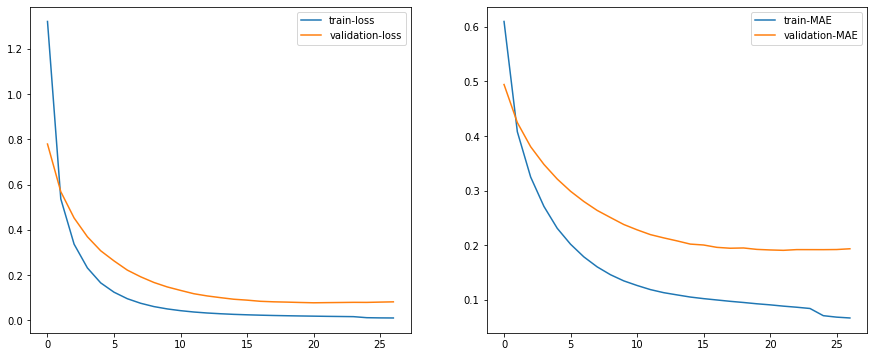

In [22]:
f, axs = plt.subplots(1,2,figsize=(15,6))
plt.subplot(121)
plt.plot(history.history['loss'], label='train-loss')
plt.plot(history.history['val_loss'], label='validation-loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['mae'], label='train-MAE')
plt.plot(history.history['val_mae'], label='validation-MAE')
plt.legend()

In [23]:
model.save(f"triplet_loss_{data_type}")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: triplet_loss_nondisjoint/assets


In [24]:
with open(image_embedding_file, "rb") as fr:
    image_embedding_dict = pickle.load(fr)
print(f"Loaded {len(image_embedding_dict)} image embeddings")

Loaded 261057 image embeddings


In [54]:
inp = tf.keras.layers.Input(shape=[1280])
inp2 = tf.stack([inp, inp, inp], axis=1)
out = model.layers[2](inp2)
out2 = out[:,0,:]
image_model = tf.keras.models.Model(inputs=inp, outputs=out2)
image_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           [(None, 1280)]       0                                            
__________________________________________________________________________________________________
tf_op_layer_stack_17 (TensorFlo [(None, 3, 1280)]    0           input_46[0][0]                   
                                                                 input_46[0][0]                   
                                                                 input_46[0][0]                   
__________________________________________________________________________________________________
time_distributed_18 (TimeDistri multiple             327936      tf_op_layer_stack_17[0][0]       
___________________________________________________________________________________________

In [59]:
triplet_image_dict = {}
for item, x in tqdm(image_embedding_dict.items()):
    y = tf.squeeze(image_model(tf.expand_dims(x, axis=0)))
    triplet_image_dict[item] = y

100%|██████████| 261057/261057 [11:08<00:00, 390.65it/s]


In [60]:
with open(os.path.join(embed_dir, "triplet_polyvore_image.pkl"), "wb") as output_file:
    pickle.dump(triplet_image_dict, output_file)

### Write new text embeddings

In [61]:
inp = tf.keras.layers.Input(shape=[768])
inp2 = tf.stack([inp, inp, inp], axis=1)
out = model.layers[3](inp2)
out2 = out[:,0,:]
text_model = tf.keras.models.Model(inputs=inp, outputs=out2)
text_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           [(None, 768)]        0                                            
__________________________________________________________________________________________________
tf_op_layer_stack_18 (TensorFlo [(None, 3, 768)]     0           input_47[0][0]                   
                                                                 input_47[0][0]                   
                                                                 input_47[0][0]                   
__________________________________________________________________________________________________
time_distributed_19 (TimeDistri (None, 3, 256)       196864      tf_op_layer_stack_18[0][0]       
___________________________________________________________________________________________

In [25]:
text_embedding_file = os.path.join(embed_dir, "bert_polyvore.pkl")
with open(text_embedding_file, "rb") as fr:
    text_embedding_dict = pickle.load(fr)
print(f"Loaded {len(text_embedding_dict)} text embeddings")

Loaded 251008 text embeddings


In [62]:
triplet_text_dict = {}
for item, x in tqdm(text_embedding_dict.items()):
    y = tf.squeeze(text_model(tf.expand_dims(x, axis=0)))
    triplet_text_dict[item] = y

100%|██████████| 251008/251008 [11:01<00:00, 379.31it/s]


In [63]:
with open(os.path.join(embed_dir, "triplet_polyvore_text.pkl"), "wb") as output_file:
    pickle.dump(triplet_text_dict, output_file)

In [27]:
model.layers